# Exploratory Discovery Analysis

In this notebook we explore the provided data. First, let set up the environment for the notebook

In [76]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import pandas as pd
import matplotlib.pyplot as plt

In [78]:
# DATA CONFIG
TRAIN_DATA = "data/train.csv"
EXISTING_MRT_DATA = "data/auxiliary-data/auxiliary-data/sg-mrt-existing-stations.csv"

The training data is provided in the `train.csv` file.

In [79]:
train_df = pd.read_csv(TRAIN_DATA)
train_df.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


# Data Preprocessing
There are several attributes we need to normalize the values.
Let start with `flat_type`

<Axes: ylabel='flat_type'>

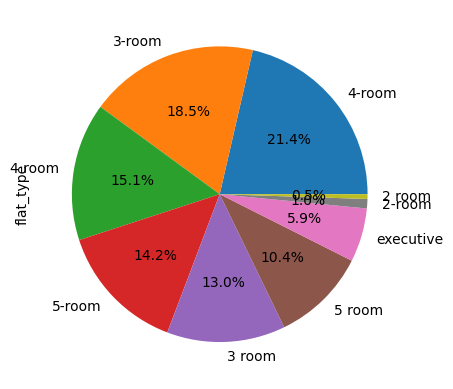

In [80]:
train_df.flat_type.value_counts().plot.pie(autopct="%1.1f%%")

We notice that there is an issue here, 2 room flat can be set as `2 room` or `2-room`. Let clean them up by removing the hyphen.

<Axes: ylabel='flat_type'>

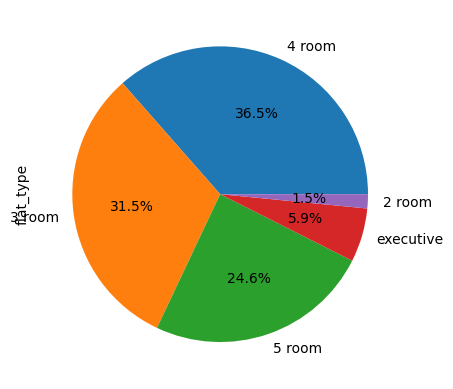

In [81]:
train_df.flat_type = train_df.flat_type.str.replace('-', ' ')
train_df.flat_type.value_counts().plot.pie(autopct="%1.1f%%")

After fixing the values, we can see the most common apartment for rent is 4 room apartments (36.5%), 3 room (31.5%) and 5 room aparments 24.6%)

## Transforming duplicates records

In [82]:
attr_cols = list(train_df.columns.drop('monthly_rent'))
duplicate_indexes = train_df[attr_cols].duplicated()
num_duplicate_records = duplicate_indexes.sum()
print(f"There are {num_duplicate_records} ({num_duplicate_records/len(train_df):.2%}) in the train data")

There are 3457 (5.76%) in the train data


In [83]:
train_df[duplicate_indexes]

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
725,2021-03,ang mo kio,649,ang mo kio avenue 5,3 room,new generation,75.0,yes,1980,1.377763,103.843782,0.0,yio chu kang west,ang mo kio,north-east region,2300
801,2021-01,tampines,157,Tampines Street 12,3 room,new generation,82.0,yes,1985,1.351073,103.945004,0.0,tampines east,tampines,east region,1850
832,2022-11,bishan,407,sin ming avenue,3 room,simplified,64.0,yes,1986,1.363453,103.834215,0.0,upper thomson,bishan,central region,1850
885,2021-02,bukit merah,38,jalan rumah tinggi,4 room,model a,100.0,yes,1997,1.288634,103.809644,0.0,alexandra hill,bukit merah,central region,2950
1184,2023-05,bedok,412,Bedok North Avenue 2,3 room,new generation,67.0,yes,1979,1.329291,103.931091,0.0,bedok north,bedok,east region,2600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59955,2022-03,jurong west,209,boon lay place,3 room,improved,65.0,yes,1976,1.346258,103.715155,0.0,boon lay place,jurong west,west region,2000
59960,2022-02,clementi,611,clementi west street 1,3 room,model a,74.0,yes,1983,1.303697,103.769477,0.0,clementi woods,clementi,west region,2050
59968,2022-07,ang mo kio,433,ang mo kio avenue 10,3 room,new generation,67.0,yes,1979,1.368077,103.854353,0.0,chong boon,ang mo kio,north-east region,1250
59969,2021-08,sengkang,275b,compassvale link,4 room,premium apartment,90.0,yes,2009,1.383339,103.894522,0.0,compassvale,sengkang,north-east region,2950


In [84]:
dedup_traindf = train_df.groupby(attr_cols).mean().reset_index()

In [85]:
# make sure that there is no duplicate records
num_duplicate_left = dedup_traindf.duplicated().sum()
print(f"Number of duplicates record after processing {num_duplicate_left}")

Number of duplicates record after processing 0


## Relationships between facilities and the premise

Using great circle formula, we can calculate the distance (in term of meters) between the premise and other facilities such as MRTs, malls, and primary schools.

First, let see the relationship between distance to MRT and monthly rent. Note that there are several MRT stations having the same location, e.g. NS1/EW24. For those stations, we can safely keep only 1.

In [86]:
from preprocessing import distance_to_nearest_place

MRT_DATAFRAME_PATH = "data/auxiliary-data/auxiliary-data/sg-mrt-existing-stations.csv"
POSITION_ATTRS = ['latitude', 'longitude']
mrt_df = pd.read_csv(MRT_DATAFRAME_PATH).drop_duplicates(POSITION_ATTRS)
dedup_traindf[['nearest_mrt_dist', 'nearest_mrt_code']] = \
    dedup_traindf.apply(
        lambda row: distance_to_nearest_place(row, mrt_df, 'code'),
        axis=1,
        result_type="expand"
)

In [87]:
mrt_df.head()

,code,name,opening_year,latitude,longitude
0,NS1,Jurong East,1990,1.333295,103.742154
1,NS2,Bukit Batok,1990,1.349035,103.749526
2,NS3,Bukit Gombak,1990,1.358663,103.751913
3,NS4,Choa Chu Kang,1990,1.385363,103.744371
4,NS5,Yew Tee,1996,1.397476,103.747418


Before plotting, instead of using `monthly_rent` we can use monthly rent per square meters to normalize the rental.

In [88]:
dedup_traindf['rent_per_sq'] = dedup_traindf['monthly_rent'] / dedup_traindf['floor_area_sqm']
# NUM_SAMPLES = 500
# samples = dedup_traindf[(dedup_traindf.rent_approval_date == "2021-03") & (dedup_traindf.flat_type == "3 room")]
# samples = samples.sample(NUM_SAMPLES)
samples = dedup_traindf

<Axes: >

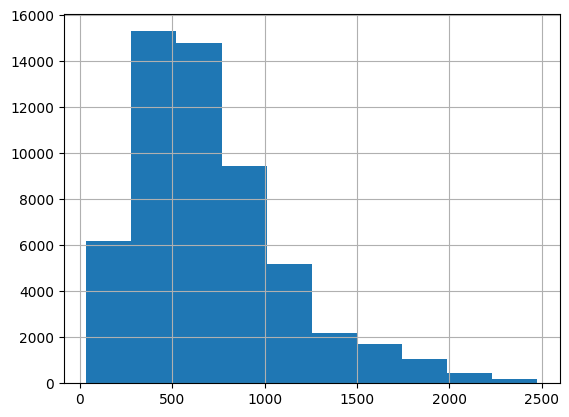

In [89]:
samples.nearest_mrt_dist.hist()

<Axes: xlabel='nearest_mrt_dist', ylabel='rent_per_sq'>

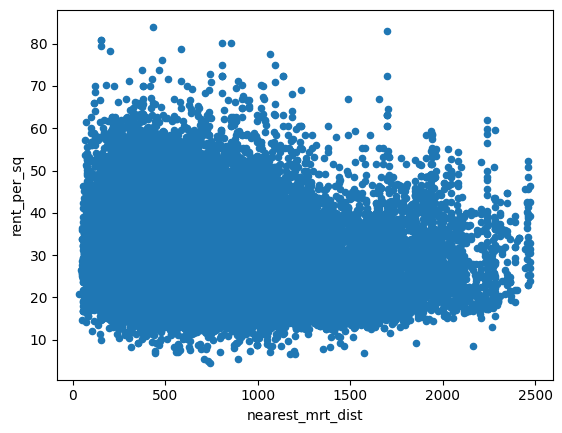

In [90]:
samples.plot.scatter(x='nearest_mrt_dist', y='rent_per_sq')

Most of the premises are 200-600 meters from its closest MRT. There are few apartments that are more than 1000 meters from a MRT. 

<Axes: ylabel='nearest_mrt_code'>

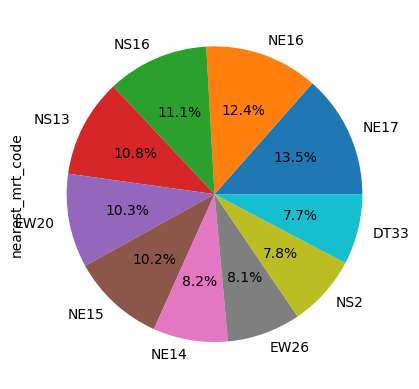

In [91]:
dedup_traindf.nearest_mrt_code.value_counts().nlargest(10).plot.pie(autopct="%1.1f%%")

<Axes: xlabel='nearest_mrt_dist', ylabel='rent_per_sq'>

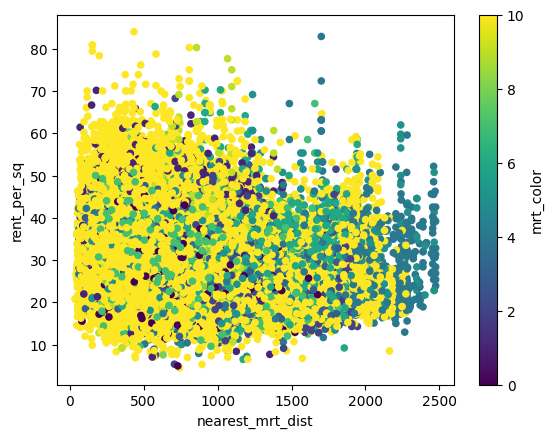

In [92]:
top_nearest_mrts = dedup_traindf.nearest_mrt_code.value_counts().nlargest(10).index
mrts_to_ints = pd.Categorical(top_nearest_mrts).codes
mrts_to_ints = dict(zip(top_nearest_mrts, mrts_to_ints))
mrts_to_ints.update({mrt: 10 for mrt in dedup_traindf.nearest_mrt_code.unique() if mrt not in mrts_to_ints.keys()})
samples['mrt_color'] = samples.nearest_mrt_code.map(mrts_to_ints)
samples.plot.scatter(x='nearest_mrt_dist', y='rent_per_sq', c='mrt_color', colormap='viridis')

## Auxiliary Data - Planned MRT Stations.

Exploring relationships between rental and planned MRT stations. 

In [93]:
from preprocessing import distance_to_nearest_place

planned_mrt_df = pd.read_csv(PLANNED_MRT_DATA)

POSITION_ATTRS = ['latitude', 'longitude']
planned_mrt_df = planned_mrt_df.drop_duplicates(POSITION_ATTRS)
train_df[['nearest_planned_mrt_dist', 'station_name']] = \
    train_df.apply(
        lambda row: distance_to_nearest_place(row, planned_mrt_df, 'name'),
        axis=1,
        result_type="expand"
    )

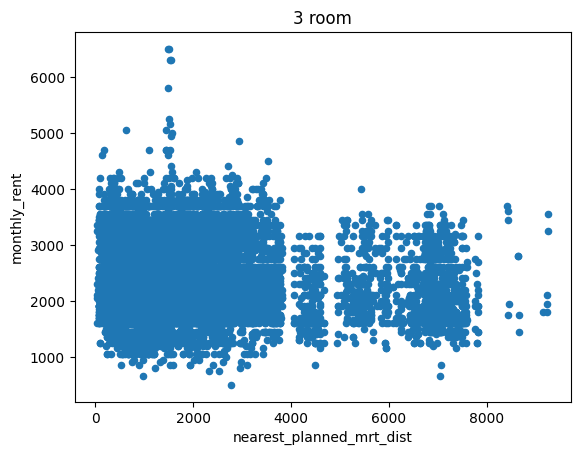

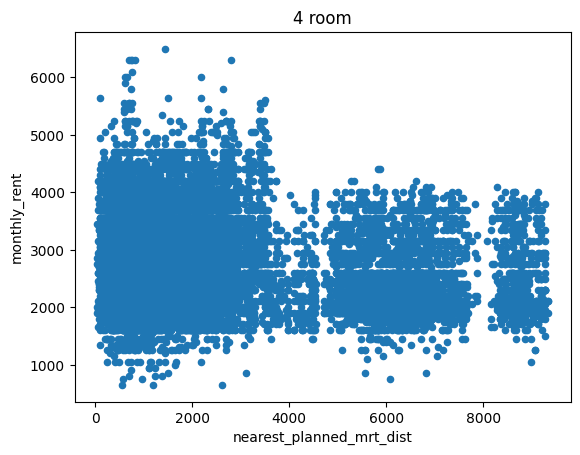

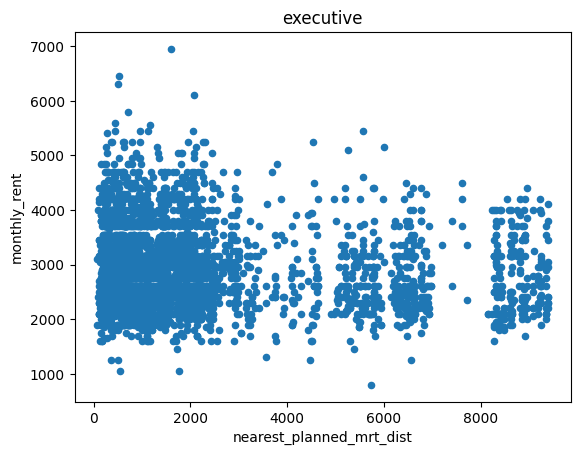

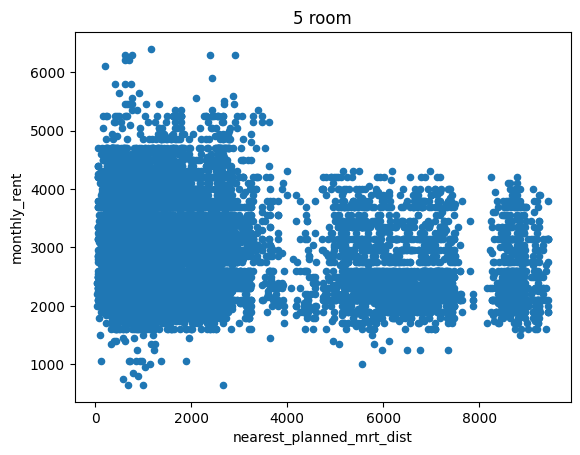

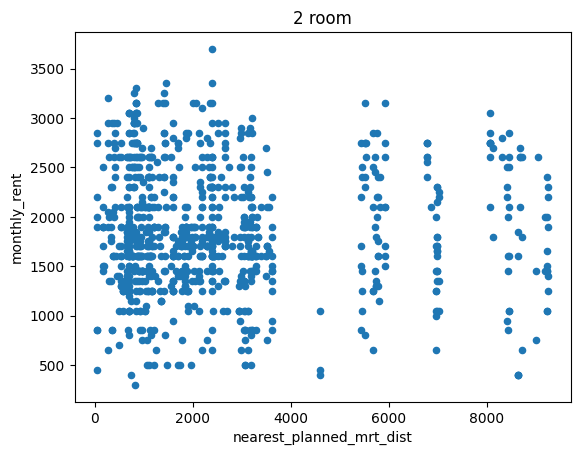

In [94]:
flat_types = train_df["flat_type"].unique()
overall_df = train_df[["flat_type", "nearest_planned_mrt_dist", "monthly_rent"]]
for ft in flat_types:
    flat_mrt_rent_df = overall_df[overall_df["flat_type"]==ft]
    flat_mrt_rent_df.plot.scatter(x="nearest_planned_mrt_dist", y="monthly_rent", title=f"{ft}")

# Nearest distance to malls and schools

In [95]:
SHOPPING_DATAFRAME_PATH = "data/auxiliary-data/auxiliary-data/sg-shopping-malls.csv"
mall_df = pd.read_csv(SHOPPING_DATAFRAME_PATH).drop_duplicates(POSITION_ATTRS)
samples[['nearest_mall_dist', 'nearest_mall_name']] = \
    samples.apply(
        lambda row: distance_to_nearest_place(row, mall_df, 'name'),
        axis=1,
        result_type="expand"
)

SCHOOL_DATAFRAME_PATH = "data/auxiliary-data/auxiliary-data/sg-primary-schools.csv"
school_df = pd.read_csv(SCHOOL_DATAFRAME_PATH).drop_duplicates(POSITION_ATTRS)
samples[['nearest_school_dist', 'nearest_school_name']] = \
    samples.apply(
        lambda row: distance_to_nearest_place(row, school_df, 'name'),
        axis=1,
        result_type="expand"
)

# Assuming 'samples' is your DataFrame
samples['year'] = samples['rent_approval_date'].str[:4]

## Distribution of rental price between years

<Axes: ylabel='year'>

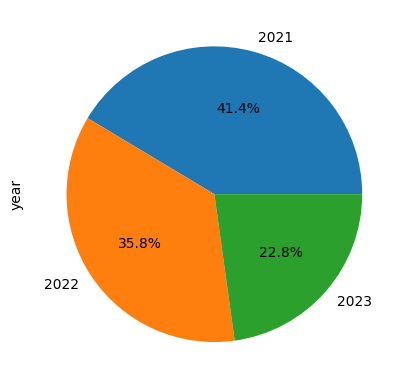

In [96]:
samples.year.value_counts().plot.pie(autopct="%1.1f%%")

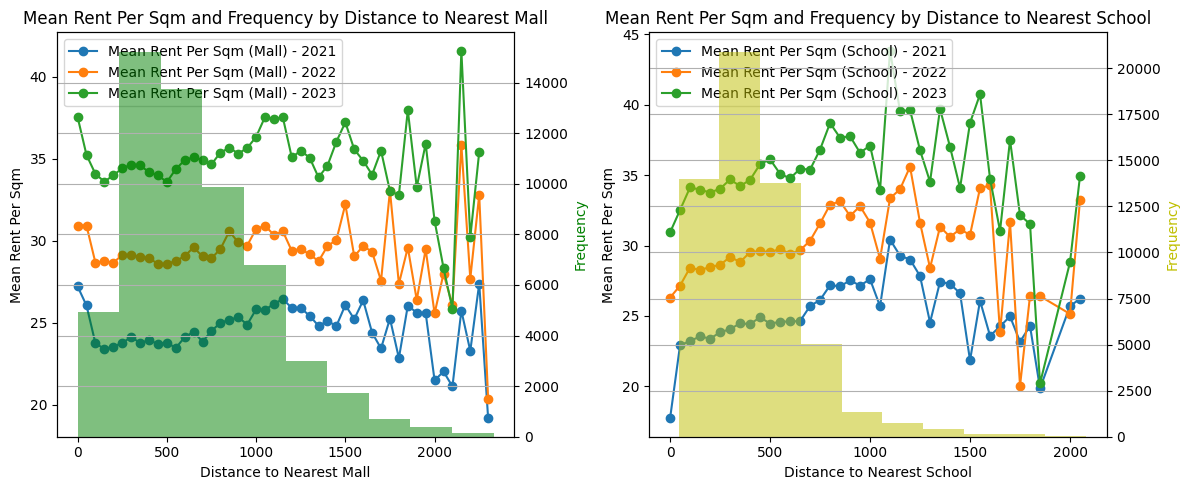

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot for 'nearest_mall_dist'
grouped_mean_mall = samples.groupby(samples['nearest_mall_dist'] // 50 * 50)['rent_per_sq'].mean()

# Plot for 'nearest_school_dist'
grouped_mean_school = samples.groupby(samples['nearest_school_dist'] // 50 * 50)['rent_per_sq'].mean()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Iterate through unique years and plot lines for 'nearest_mall_dist'
for year in samples['year'].unique():
    subset = samples[samples['year'] == year]
    grouped_mean = subset.groupby(subset['nearest_mall_dist'] // 50 * 50)['rent_per_sq'].mean()
    ax1.plot(grouped_mean.index, grouped_mean, marker='o', label=f'Mean Rent Per Sqm (Mall) - {year}')

# Set labels and legend for the first subplot
ax1.set_xlabel('Distance to Nearest Mall')
ax1.set_ylabel('Mean Rent Per Sqm')
ax1.legend(loc='upper left')
ax1.set_title('Mean Rent Per Sqm by Distance to Nearest Mall')

# Plot the histogram of 'nearest_mall_dist'
ax1_2 = ax1.twinx()
samples['nearest_mall_dist'].hist(ax=ax1_2, bins=10, color='g', alpha=0.5)
ax1_2.set_ylabel('Frequency', color='g')

# Show legends for the first plot
ax1.legend(loc='upper left')
ax1.set_title('Mean Rent Per Sqm and Frequency by Distance to Nearest Mall')

# Iterate through unique years and plot lines for 'nearest_school_dist'
for year in samples['year'].unique():
    subset = samples[samples['year'] == year]
    grouped_mean = subset.groupby(subset['nearest_school_dist'] // 50 * 50)['rent_per_sq'].mean()
    ax2.plot(grouped_mean.index, grouped_mean, marker='o', label=f'Mean Rent Per Sqm (School) - {year}')

# Set labels and legend for the second subplot
ax2.set_xlabel('Distance to Nearest School')
ax2.set_ylabel('Mean Rent Per Sqm')
ax2.legend(loc='upper left')
ax2.set_title('Mean Rent Per Sqm by Distance to Nearest School')

# Plot the histogram of 'nearest_school_dist'
ax2_2 = ax2.twinx()
samples['nearest_school_dist'].hist(ax=ax2_2, bins=10, color='y', alpha=0.5)
ax2_2.set_ylabel('Frequency', color='y')

# Show legends for the second plot
ax2.legend(loc='upper left')
ax2.set_title('Mean Rent Per Sqm and Frequency by Distance to Nearest School')

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()


<Axes: xlabel='nearest_mall_dist', ylabel='rent_per_sq'>

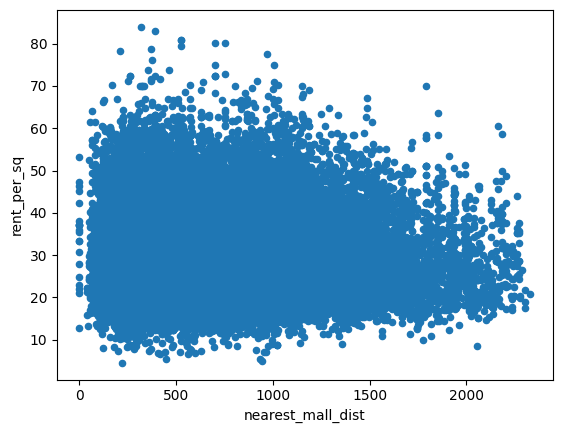

In [98]:
samples.plot.scatter(x='nearest_mall_dist', y='rent_per_sq')

From those figures, we have some observations:

- Most of the apartments are less than 1km from the closest MRT, and 1.5km from the nearest mall.
- Although both signals are not signaficant to completely control the monthly rent, we can see some trends.

For example, if the apartment is too far from facility, its monthly rent cannot be higher than the average.

<Axes: xlabel='nearest_school_dist', ylabel='rent_per_sq'>

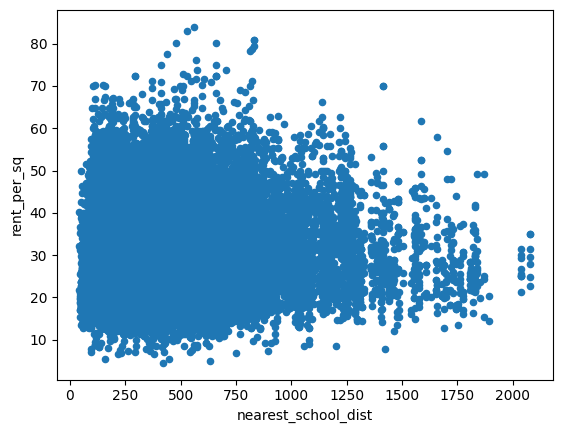

In [99]:
samples.plot.scatter(x='nearest_school_dist', y='rent_per_sq')

The distribution seeing here is pretty similar to nearest mall:
- meaning the distance does not affect the monthly rent much.

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Monthly Rental per Sqm Heatmap

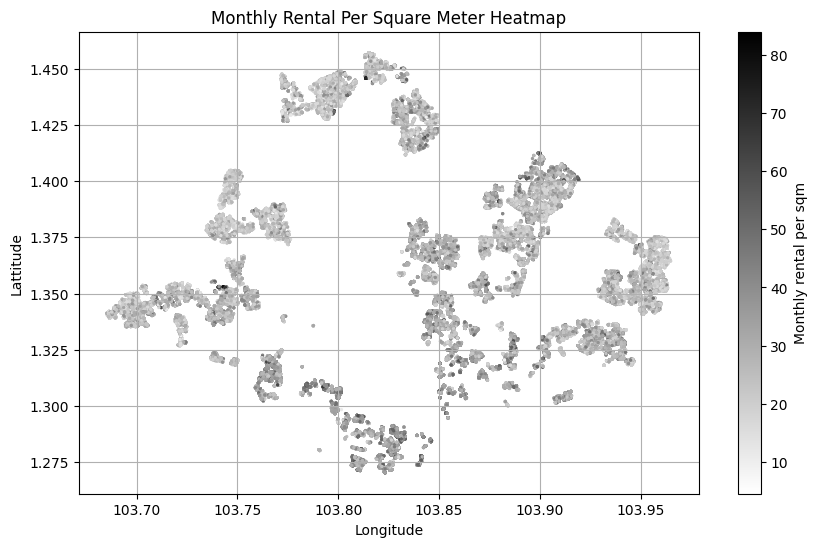

In [101]:
df_train = pd.read_csv("./data/train.csv")

df_train['rent_sqm'] = df_train['monthly_rent'] / df_train['floor_area_sqm']

def plot_rental_heatmap(df):
    df_temp = df.copy()
    plt.figure(figsize=(10,6))
    plt.scatter(df_temp['longitude'], df_temp['latitude'], c=df_temp['rent_sqm'], cmap='binary', marker='o', s=2)
    plt.colorbar(label='Monthly rental per sqm')
    plt.xlabel('Longitude')
    plt.ylabel('Lattitude')
    plt.title('Monthly Rental Per Square Meter Heatmap')
    plt.grid(True)
    plt.show()

def plot_rental_contour(df):
    df_temp = df.copy()
    plt.figure(figsize=(10,6))
    contour = plt.tricontourf(df_temp['longitude'], df_temp['latitude'], df_temp['rent_sqm'], cmap='cool')
    plt.colorbar(contour, label='Monthly rental per sqm')
    plt.xlabel('Longitude')
    plt.ylabel('Lattitude')
    plt.title('Monthly Rental Per Square Meter Contour Plot')
    plt.grid(True)
    plt.show()

plot_rental_heatmap(df_train)

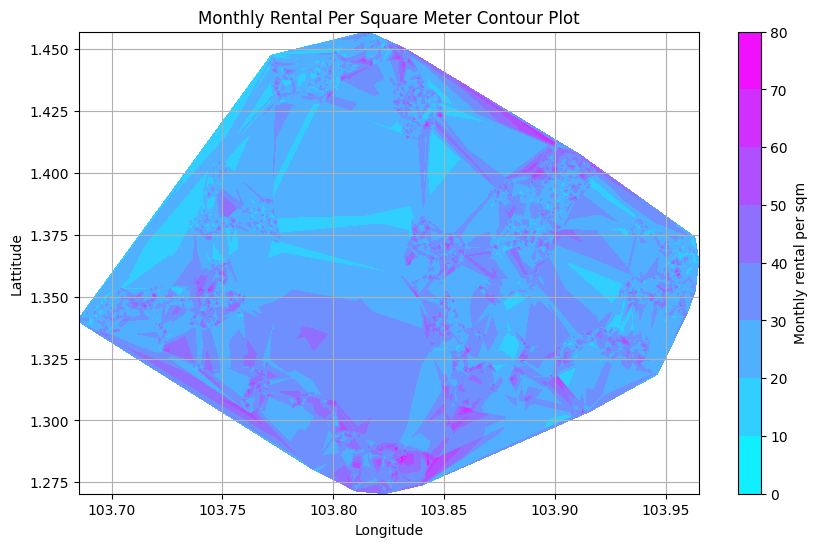

In [102]:
plot_rental_contour(df_train)

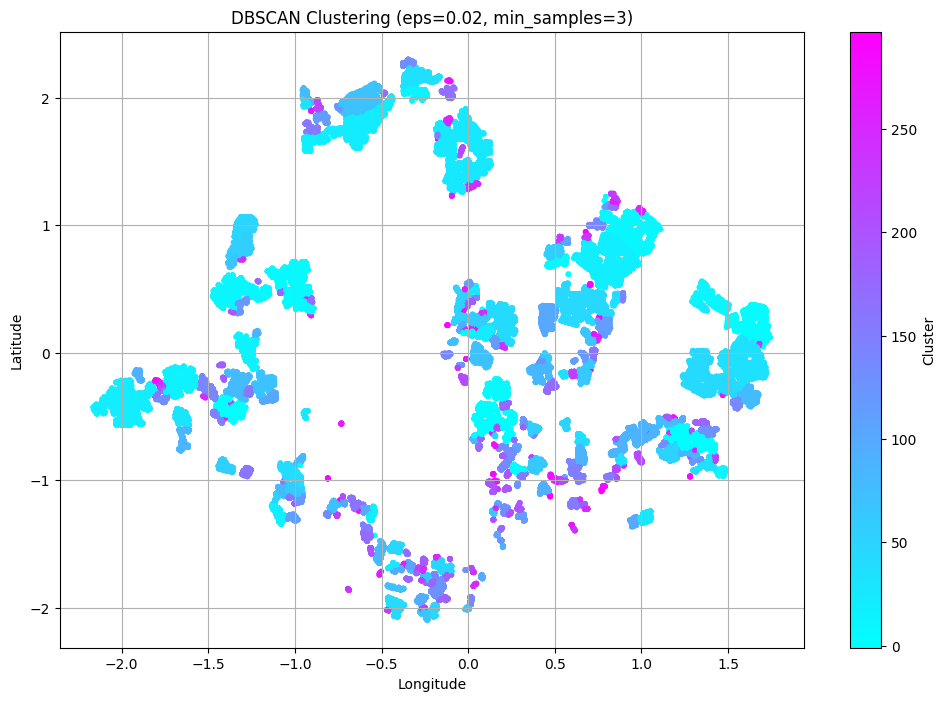

In [103]:
scaler = StandardScaler()
df_train[['latitude', 'longitude', 'rent_sqm']] = scaler.fit_transform(df_train[['latitude', 'longitude', 'rent_sqm']])

eps = 0.02
min_samples = 3
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(df_train[['latitude', 'longitude']])

plt.figure(figsize=(12, 8))
plt.scatter(df_train['longitude'], df_train['latitude'], c=clusters, cmap='cool', marker='o', s=10)
plt.colorbar(label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
plt.grid(True)
plt.show()

This hows a combination of the heatmap and the contour plot. The heatmap shows the density of the data points while the contour plot shows the monthly rental per square meter.

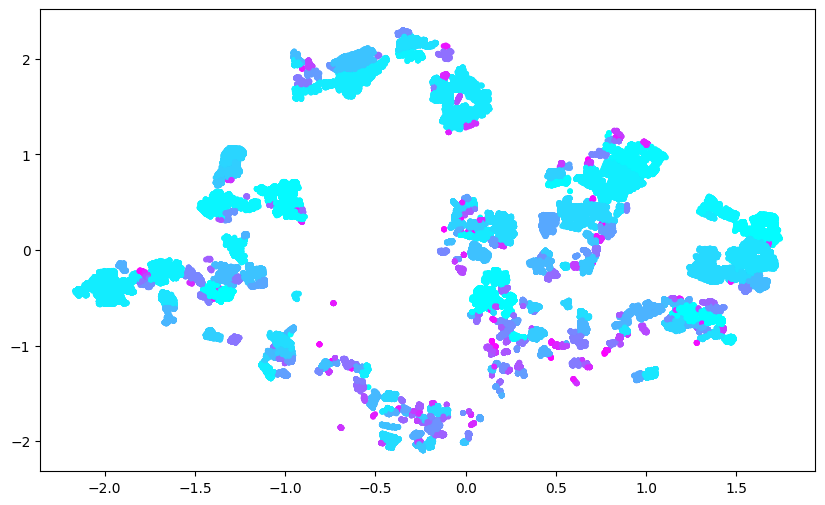

In [104]:
np.sort(clusters)
plt.figure(figsize=(10,6))
plt.scatter(df_train['longitude'], df_train['latitude'], c=clusters, cmap='cool', s=10)
plt.show()

# Finding Correlations on stock prices

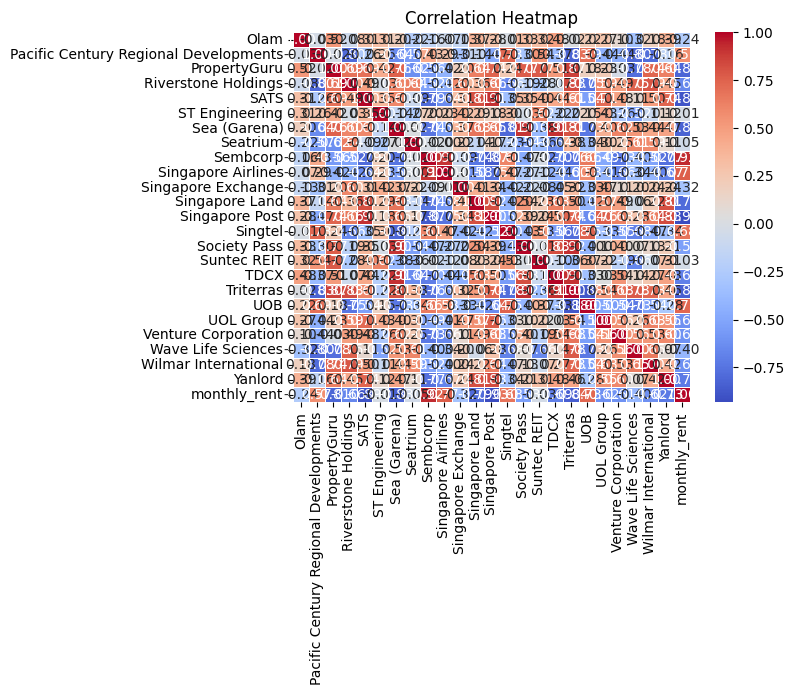

In [105]:
df_stock = pd.read_csv("./data/auxiliary-data/sg-stock-prices.csv")
df_stock['date'] = pd.to_datetime(df_stock['date'])
df_stock = df_stock.set_index('date')
df_stock['date'] = df_stock.index.strftime('%Y-%m')
df_stock = df_stock.set_index('date')

df_train = pd.read_csv("./data/train.csv")
# Group by Year-Month and calculate the average price for each stock
monthly_avg_prices = df_stock.groupby(['date', 'name'])['adjusted_close'].mean().reset_index()

# Pivot the data to create a DataFrame with stocks as columns and Year-Month as index
monthly_avg_prices_pivot = monthly_avg_prices.pivot(index='date', columns='name', values='adjusted_close')


df_train['rent_approval_date'] = pd.to_datetime(df_train['rent_approval_date'])
df_train = df_train.set_index('rent_approval_date')
df_train['rent_approval_date'] = df_train.index.strftime('%Y-%m')
df_train = df_train.set_index('rent_approval_date')

average_rental = df_train.groupby(df_train.index)['monthly_rent'].mean().reset_index()
average_rental = average_rental.set_index('rent_approval_date')

# Merge the two dataframes based on the Year-Month index
merged_data = monthly_avg_prices_pivot.join(average_rental)

correlations = merged_data.corr()

sns.heatmap(correlations.iloc[-25:,-25:], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Monthly rental per flat type discovery

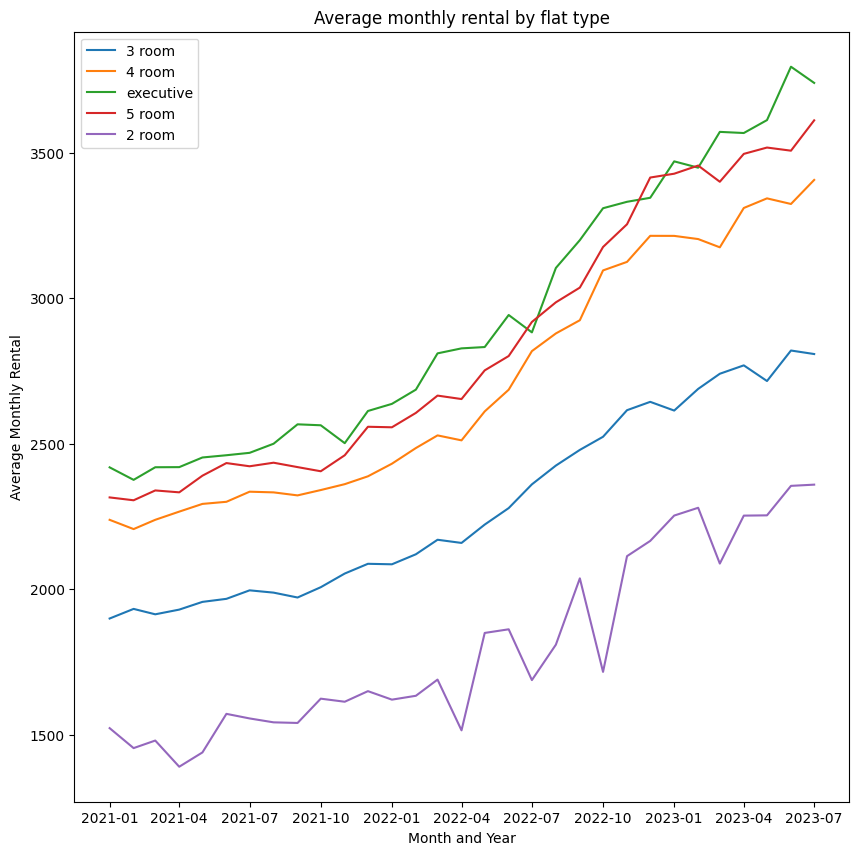

In [106]:
from datetime import datetime

TRAIN_DATA = "data/train.csv"
EXISTING_MRT_DATA= "data/auxiliary-data/auxiliary-data/sg-mrt-existing-stations.csv"
PLANNED_MRT_DATA = "data/auxiliary-data/auxiliary-data/sg-mrt-planned-stations.csv"
SHOPPING_MALL_DATA = "data/auxiliary-data/auxiliary-data/sg-shopping-malls.csv"
PRIMARY_SCHOOL = "data/auxiliary-data/auxiliary-data/sg-primary-schools.csv"
COE_PRICE_DATA = "data/auxiliary-data/auxiliary-data/sg-coe-prices.csv"
STOCK_PRICE_DATA = "data/auxiliary-data/auxiliary-data/sg-stock-prices.csv"

train_df = pd.read_csv(TRAIN_DATA)

train_df["lease_commence_date"] = train_df["lease_commence_date"].apply(lambda x: datetime(x, 1, 1))
train_df["rent_approval_date"] = pd.to_datetime(train_df["rent_approval_date"])
no_duplicate_train = train_df.drop_duplicates()
no_duplicate_train.shape
train_df['flat_type'] = train_df["flat_type"].str.replace('-', ' ')
rental_by_date = train_df.sort_values(by=["monthly_rent"])

flat_types = train_df['flat_type'].unique()
plt.figure(figsize=(10, 10))
for type in flat_types:
    rental_by_date_by_room = rental_by_date[rental_by_date["flat_type"]==type][["rent_approval_date", "monthly_rent"]]
    df_plot = rental_by_date_by_room.groupby("rent_approval_date").mean().reset_index()
    plt.plot(df_plot["rent_approval_date"], df_plot["monthly_rent"], label=type, )

plt.xlabel("Month and Year")
plt.ylabel("Average Monthly Rental")
plt.legend()
plt.title("Average monthly rental by flat type")
plt.show()


As we can see from the above plot, the rent increase from 2 room, 3 room, 4 room, 5 room and the highest being executive. They stayed in their own range with only occasional overlapping between 5 room and executive. We can also see the rental price has been increasing steadily (or quite a bit) since year 2021. 

### Relationship between data attributes

<Axes: xlabel='monthly_rent', ylabel='floor_area_sqm'>

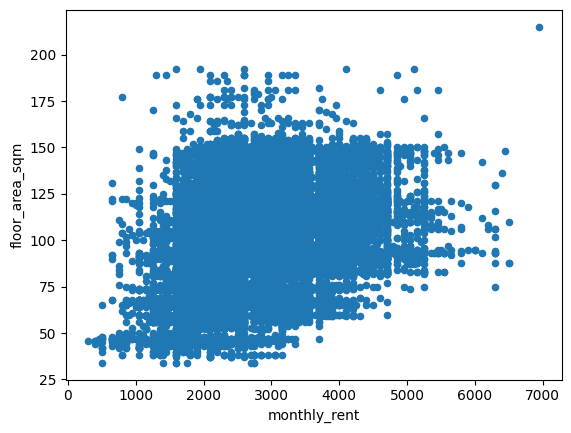

In [107]:
train_df.plot.scatter("monthly_rent", "floor_area_sqm")

<Axes: xlabel='monthly_rent', ylabel='town'>

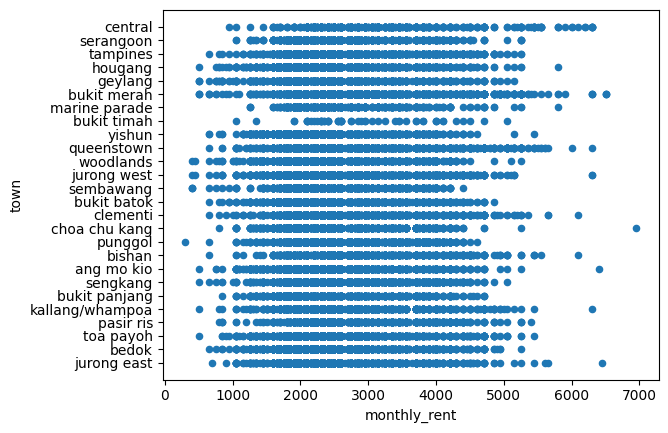

In [108]:
train_df.plot.scatter("monthly_rent", "town")

<Axes: xlabel='region', ylabel='town'>

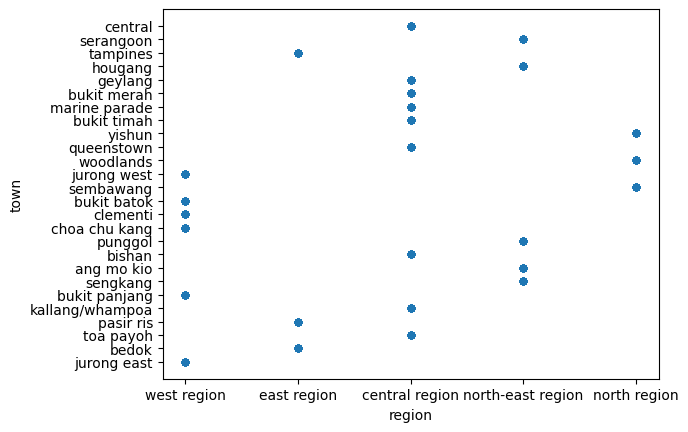

In [109]:
train_df.plot.scatter("region", "town")

<Axes: xlabel='monthly_rent', ylabel='region'>

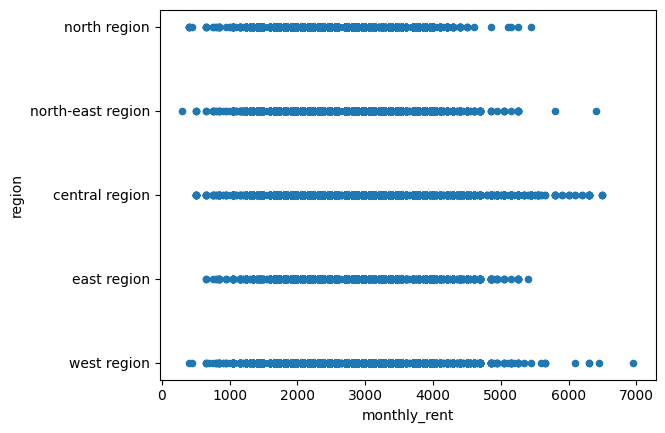

In [110]:
train_df.plot.scatter("monthly_rent", "region")

<Axes: title={'center': 'monthly_rent'}, xlabel='region'>

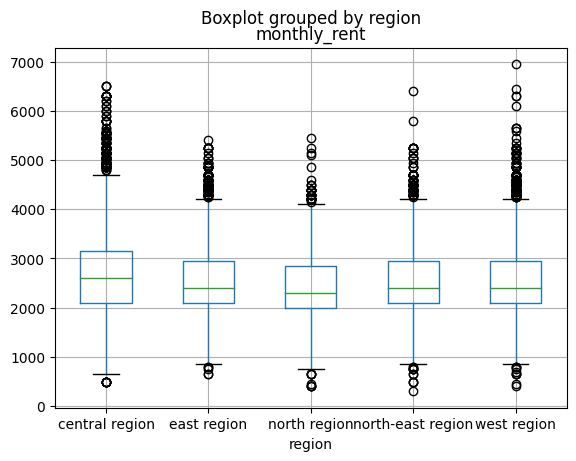

In [111]:
train_df.boxplot(column=["monthly_rent"], by="region")

<Axes: title={'center': 'monthly_rent'}, xlabel='flat_type'>

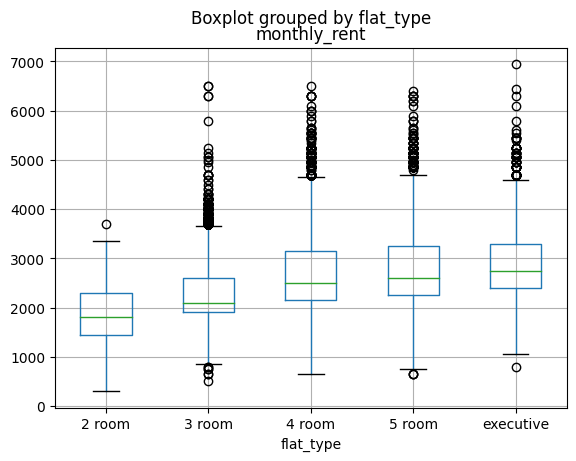

In [112]:
train_df.boxplot(column=["monthly_rent"], by="flat_type")

<Axes: xlabel='monthly_rent', ylabel='flat_type'>

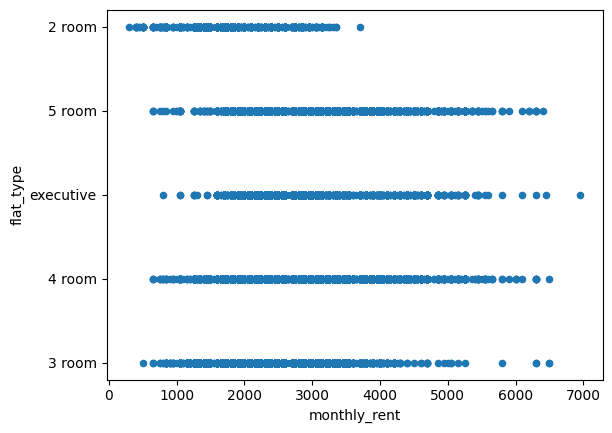

In [113]:
train_df.plot.scatter("monthly_rent", "flat_type")